# Graph Networts

In [197]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
#import libraries and some constants

import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import tensorflow as tf

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

import uproot3 as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mfong/git/LCStudies/'
plotpath = path_prefix + 'classifier/Plots/'
modelpath = path_prefix + 'classifier/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

SEED = 42
np.random.seed(SEED)
# tf.random.set_seed(SEED)

In [199]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
sys.path
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu

In [200]:
tf.test.gpu_device_name()

RuntimeError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [191]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices()


Num GPUs Available:  0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [5]:
# import pi+- vs. pi0 images

# inputpath = '/clusterfs/ml4hep/mfong/ML4Pions/v7/'
inputpath = "/data0/mfong/v7/"
#path = '/eos/user/m/mswiatlo/images/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {
    rfile : ur.open(inputpath+rfile+".root")['ClusterTree']
    for rfile in rootfiles
}
pdata = {
    ifile : itree.pandas.df(branches, flatten=False)
    for ifile, itree in trees.items()
}

np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [6]:
cell_shapes = {
    'EMB1': (128,4),
    'EMB2': (16,16),
    'EMB3': (8,16),
    'TileBar0': (4,4),
    'TileBar1': (4,4),
    'TileBar2': (2,4),
}

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer)
        for layer in layers
    }
    for ifile, itree in trees.items()
}

In [7]:
pdata["pi0"].columns

Index(['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi',
       'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt',
       'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE',
       'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T',
       'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY',
       'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT',
       'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min',
       'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max',
       'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max',
       'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi',
       'cluster_cell_centerCellLayer', 'cluster_cellE_norm'],
      dtype='object')

In [8]:
n_cells = 0
for key in pcells["pi0"]:
    print(pcells["pi0"][key].shape)
    n_cells += pcells["pi0"][key].shape[1]
print("Total number of cells: " + str(n_cells))

(263891, 512)
(263891, 256)
(263891, 128)
(263891, 16)
(263891, 16)
(263891, 8)
Total number of cells: 936


## Create DataFrame

In [9]:
# df for pi0 only
df_p0 = pd.DataFrame(np.concatenate([pcells["pi0"][key] for key in pcells["pi0"].keys()], axis = 1))

col_names = []
for key in pcells["pi0"].keys():
    col_names.extend([key + "_" + str(i) for i in range(len(pcells["pi0"][key][0]))])
df_p0.columns = col_names

df_p0["is_p0"] = 1


# print(df_p0.shape)
# df_p0.head()

In [10]:
# df for pipplus and piminus
df_pp = pd.DataFrame(np.concatenate([pcells["piplus"][key] for key in pcells["piplus"].keys()], axis = 1))
df_pp.columns = col_names
df_pp["is_p0"] = 0

df_pm = pd.DataFrame(np.concatenate([pcells["piminus"][key] for key in pcells["piminus"].keys()], axis = 1))
df_pm.columns = col_names
df_pm["is_p0"] = 0

# print(df_pp.shape)
# df_pp.head()

In [11]:
# create final df
df = df_p0.append(df_pp.append(df_pm))
df = df.sample(frac=1) # Shuffle the df so pi0 are not all first
df.reset_index(inplace = True, drop = True)
df.head()

,EMB1_0,EMB1_1,EMB1_2,EMB1_3,EMB1_4,EMB1_5,EMB1_6,EMB1_7,EMB1_8,EMB1_9,EMB1_10,EMB1_11,EMB1_12,EMB1_13,EMB1_14,EMB1_15,EMB1_16,EMB1_17,EMB1_18,EMB1_19,EMB1_20,EMB1_21,EMB1_22,EMB1_23,EMB1_24,EMB1_25,EMB1_26,EMB1_27,EMB1_28,EMB1_29,EMB1_30,EMB1_31,EMB1_32,EMB1_33,EMB1_34,EMB1_35,EMB1_36,EMB1_37,EMB1_38,EMB1_39,EMB1_40,EMB1_41,EMB1_42,EMB1_43,EMB1_44,EMB1_45,EMB1_46,EMB1_47,EMB1_48,EMB1_49,...,EMB3_119,EMB3_120,EMB3_121,EMB3_122,EMB3_123,EMB3_124,EMB3_125,EMB3_126,EMB3_127,TileBar0_0,TileBar0_1,TileBar0_2,TileBar0_3,TileBar0_4,TileBar0_5,TileBar0_6,TileBar0_7,TileBar0_8,TileBar0_9,TileBar0_10,TileBar0_11,TileBar0_12,TileBar0_13,TileBar0_14,TileBar0_15,TileBar1_0,TileBar1_1,TileBar1_2,TileBar1_3,TileBar1_4,TileBar1_5,TileBar1_6,TileBar1_7,TileBar1_8,TileBar1_9,TileBar1_10,TileBar1_11,TileBar1_12,TileBar1_13,TileBar1_14,TileBar1_15,TileBar2_0,TileBar2_1,TileBar2_2,TileBar2_3,TileBar2_4,TileBar2_5,TileBar2_6,TileBar2_7,is_p0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000009,0.000038,0.000009,0.0,0.0,0.0,0.0,0.0,0.0,0.000224,0.000315,0.001344,0.000428,0.002322,0.012944,0.014262,0.002498,0.001551,0.070766,0.140632,0.001669,0.003287,0.004747,0.008165,0.000888,0.000054,0.000776,0.001186,0.000146,0.000375,0.006990,0.007225,0.003866,0.001419,0.035971,0.047344,0.003773,0.000361,0.006787,0.003358,0.002189,0.0,0.000625,0.000405,0.000031,0.000024,0.001023,0.001606,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.011872,0.005269,0.000000,0.000000,0.628931,0.088836,0.002091,0.000000,0.030488,0.019321,0.004342,0.000000,0.000000,0.000177,0.001947,0.000000,0.019718,0.003629,0.000000,0.000000,0.087662,0.022248,0.000901,0.000000,0.006445,0.000219,0.000237,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1


## Create Graphs

In [12]:
# permutations for doubly connected edges
from itertools import permutations
import functools
import networkx as nx
import sonnet as snt

from graph_nets import blocks

from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

In [13]:
# event0 = df.loc[0]
event0 = df.loc[0]
event0

EMB1_0        0.000000
EMB1_1        0.000000
EMB1_2        0.000000
EMB1_3        0.000000
EMB1_4        0.000000
                ...   
TileBar2_4    0.000024
TileBar2_5    0.001023
TileBar2_6    0.001606
TileBar2_7    0.000000
is_p0         0.000000
Name: 0, Length: 937, dtype: float64

In [14]:
def make_fully_connected_edges(nodes):
    """
    returns a list of tuples with (sender_node, reciever_node) for a fully connected graph
    ex: [(1,2), (2,1), (0,1)]
    """
    n_nodes = len(nodes)
    return list(permutations(range(n_nodes), 2))

In [39]:
def make_graph(event):
    
    n_nodes = 0
    nodes = []
    MIN_VALUE = 0.01
    solution = "is_p0"
    
    nodes = [[cell] for cell in event[col_names][event[col_names] > MIN_VALUE]]
    n_nodes = len(nodes)
    if n_nodes < 1:
        return (None, None)
    nodes = np.array(nodes, dtype=np.float32)
    
    edge_endpoints = make_fully_connected_edges(nodes)
    senders = np.array([x[0] for x in edge_endpoints])
    receivers = np.array([x[1] for x in edge_endpoints])
    n_edges = len(edge_endpoints)
    edges = np.expand_dims(np.array([0.0]*n_edges, dtype=np.float32), axis=1)

    
    input_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([n_nodes], dtype=np.float32)
    }
    target_datadict = {
        "n_node": n_nodes,
        "n_edge": n_edges,
        "nodes": nodes,
        "edges": edges,
        "senders": senders,
        "receivers": receivers,
        "globals": np.array([event[solution]], dtype=np.float32)
    }
    input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])
    target_graph = utils_tf.data_dicts_to_graphs_tuple([target_datadict])
    
    return (input_graph, target_graph)

In [40]:
def print_graphs_tuple(g, data=True):
    for field_name in graphs.ALL_FIELDS:
        per_replica_sample = getattr(g, field_name)
        if per_replica_sample is None:
            print(field_name, "EMPTY")
        else:
            print(field_name, "has shape", per_replica_sample.shape)
            if data and  field_name != "edges":
                print(per_replica_sample)

In [41]:
graphs_tuple0_input, graphs_tuple0_target = make_graph(event0)

print_graphs_tuple(graphs_tuple0_input, data=False)

nodes has shape (14, 1)
edges has shape (182, 1)
receivers has shape (182,)
senders has shape (182,)
globals has shape (1, 1)
n_node has shape (1,)
n_edge has shape (1,)


In [42]:
# plotting functions from example (broken)

# def plot_graph_networkx(graph, ax, pos=None):
#   node_labels = {node: "{:.3g}".format(data["features"][0])
#                  for node, data in graph.nodes(data=True)
#                  if data["features"] is not None}
#   edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
#                  for sender, receiver, data in graph.edges(data=True)
#                  if data["features"] is not None}
#   global_label = ("{:.3g}".format(graph.graph["features"][0])
#                   if graph.graph["features"] is not None else None)

#   if pos is None:
#     pos = nx.spring_layout(graph)
#   nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

#   if edge_labels:
#     nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

#   if global_label:
#     plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

#   ax.yaxis.set_visible(False)
#   ax.xaxis.set_visible(False)
#   return pos

# def plot_graphs_tuple(graphs_tuple):
#   networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
#   num_graphs = len(networkx_graphs)
#   _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
#   if num_graphs == 1:
#     axes = axes,
#   for graph, ax in zip(networkx_graphs, axes):
#     plot_graph_networkx(graph, ax)

# plot_graphs_tuple(graphs_tuple0_input)

## Graph net

In [43]:
# Need the newest dev version of graph_nets (see https://github.com/deepmind/graph_nets/issues/139)
# as of 3/25/2021


# !pip install git+git://github.com/deepmind/graph_nets.git

In [44]:
NUM_LAYERS = 2
def make_mlp_model():
  """Instantiates a new MLP, followed by LayerNorm.

  The parameters of each new MLP are not shared with others generated by
  this function.

  Returns:
    A Sonnet module which contains the MLP and LayerNorm.
  """
  # the activation function choices:
  # swish, relu, relu6, leaky_relu
  return snt.Sequential([
      snt.nets.MLP([128, 64]*NUM_LAYERS,
                    activation=tf.nn.relu,
                    activate_final=True, 
                  #  dropout_rate=DROPOUT_RATE
        ),
      snt.LayerNorm(axis=-1, create_scale=True, create_offset=False)
  ])

In [45]:
class MLPGraphNetwork(snt.Module):
    """GraphIndependent with MLP edge, node, and global models."""
    def __init__(self, name="MLPGraphNetwork"):
        super(MLPGraphNetwork, self).__init__(name=name)
        self._network = modules.GraphNetwork(
            edge_model_fn=make_mlp_model,
            node_model_fn=make_mlp_model,
            global_model_fn=make_mlp_model
            )

    def __call__(self, inputs,
            edge_model_kwargs=None,
            node_model_kwargs=None,
            global_model_kwargs=None):
        return self._network(inputs,
                      edge_model_kwargs=edge_model_kwargs,
                      node_model_kwargs=node_model_kwargs,
                      global_model_kwargs=global_model_kwargs)

In [46]:
LATENT_SIZE = 128

class GlobalClassifierNoEdgeInfo(snt.Module):

    def __init__(self, name="GlobalClassifierNoEdgeInfo"):
        super(GlobalClassifierNoEdgeInfo, self).__init__(name=name)

        self._edge_block = blocks.EdgeBlock(
            edge_model_fn=make_mlp_model,
            use_edges=False,
            use_receiver_nodes=True,
            use_sender_nodes=True,
            use_globals=False,
            name='edge_encoder_block')

        self._node_encoder_block = blocks.NodeBlock(
            node_model_fn=make_mlp_model,
            use_received_edges=False,
            use_sent_edges=False,
            use_nodes=True,
            use_globals=False,
            name='node_encoder_block'
        )

        self._global_block = blocks.GlobalBlock(
            global_model_fn=make_mlp_model,
            use_edges=True,
            use_nodes=True,
            use_globals=False,
        )

        self._core = MLPGraphNetwork()
        # Transforms the outputs into appropriate shapes.
        global_output_size = 1
        global_fn =lambda: snt.Sequential([
            snt.nets.MLP([LATENT_SIZE, global_output_size],
                         name='global_output'), tf.sigmoid])

        self._output_transform = modules.GraphIndependent(None, None, global_fn)

    def __call__(self, input_op, num_processing_steps):
        latent = self._global_block(self._edge_block(self._node_encoder_block(input_op)))
        latent0 = latent

        output_ops = []
        for _ in range(num_processing_steps):
            core_input = utils_tf.concat([latent0, latent], axis=1)
            latent = self._core(core_input)
            output_ops.append(self._output_transform(latent))

        return output_ops

In [47]:
model = GlobalClassifierNoEdgeInfo()

In [48]:
output_graphs = model(graphs_tuple0_input, 10)

In [49]:
[x.globals for x in output_graphs]

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3929317]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4719695]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5299183]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49676788]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.47483394]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5342472]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4988086]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.513943]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49169007]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5232188]], dtype=float32)>]

In [50]:
# Loss function:

class GlobalLoss:
    def __init__(self, real_global_weight, fake_global_weight):
        self.w_global_real = real_global_weight
        self.w_global_fake = fake_global_weight

    def __call__(self, target_op, output_ops):
        global_weights = target_op.globals * self.w_global_real \
            + (1 - target_op.globals) * self.w_global_fake
        
        print(global_weights)
        
        loss_ops = [
            tf.compat.v1.losses.log_loss(target_op.globals, output_op.globals, weights=global_weights)
            for output_op in output_ops
        ]
        return tf.stack(loss_ops)

In [51]:
loss_function_global = GlobalLoss(real_global_weight = 1.0, fake_global_weight = 1.0)

In [52]:
loss_function_global(graphs_tuple0_target, output_graphs)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.49911377, 0.638601  , 0.7548486 , 0.6867035 , 0.6440406 ,
       0.76410013, 0.69076705, 0.7214292 , 0.67666364, 0.74069744],
      dtype=float32)>

## Model Training

In [53]:
# TODO modify acc function

def compute_accuracy(target, output):
    """Calculate model accuracy.

    Returns the number of correctly predicted links and the number
    of completely solved list sorts (100% correct predictions).

    Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.

    Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.
    """
    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        num_elements = td["nodes"].shape[0]
        xn = np.argmax(td["nodes"], axis=-1)
        yn = np.argmax(od["nodes"], axis=-1)

        xe = np.reshape(
            np.argmax(
                np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
            (-1,))
        ye = np.reshape(
            np.argmax(
                np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
            (-1,))
        c = np.concatenate((xn == yn, xe == ye), axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))
    return correct, solved

In [150]:
def get_signature(dataset, batch_size):
    """
    Get signature of inputs for the training loop.
    The signature is used by the tf.function
    """

    input_list = []
    target_list = []
    for _, data in dataset.iterrows():
        dd = make_graph(data)
        if dd[0] is not None:
            input_list.append(dd[0])
            target_list.append(dd[1])
            
        if len(input_list) == batch_size:
            break

    inputs = utils_tf.concat(input_list, axis=0)
    targets = utils_tf.concat(target_list, axis=0)
    input_signature = (
      utils_tf.specs_from_graphs_tuple(inputs),
      utils_tf.specs_from_graphs_tuple(targets)
    )
    
    return input_signature

In [165]:
batch_size = 100
input_signature = get_signature(df, batch_size)


# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 50
num_processing_steps_ge = 50


learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)


# model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
generalization_iteration = 0

logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []


@functools.partial(tf.function, input_signature=input_signature)
def update_step(inputs_tr, targets_tr):
    print("Tracing update_step")
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, num_processing_steps_tr)
        loss_ops_tr = loss_function_global(targets_tr, outputs_tr)
        loss_op_tr = tf.math.reduce_sum(loss_ops_tr) / tf.constant(num_processing_steps_tr, dtype=tf.float32)

    gradients = tape.gradient(loss_op_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_op_tr

In [171]:
from sklearn.model_selection import train_test_split

# train and generalization df
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [172]:
%%time
# TODO this is very slow (1.5 hours for full 1100000 row dataset)
# make graphs for each event
train_graphs = [make_graph(event) for _, event in df_train.iterrows()]
test_graphs = [make_graph(event) for _, event in df_test.iterrows()]

CPU times: user 1h 32min 10s, sys: 4.99 s, total: 1h 32min 14s
Wall time: 1h 32min 14s


In [174]:
# save train_graphs and test_graphs objects to file, it takes too long to make
import pickle

def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

save_object(train_graphs, "Temp/train_graphs.pkl")
save_object(train_graphs, "Temp/test_graphs.pkl")


In [177]:
def loop_dataset(datasets, batch_size):
    if batch_size > 0:
        in_list = []
        target_list = []
        for dataset in datasets:
            inputs_tr, targets_tr = dataset
            if inputs_tr is None:
                continue
            in_list.append(inputs_tr)
            target_list.append(targets_tr)
            if len(in_list) == batch_size:
                inputs_tr = utils_tf.concat(in_list, axis=0)
                targets_tr = utils_tf.concat(target_list, axis=0)
                yield (inputs_tr, targets_tr)
                in_list = []
                target_list = []
    else:
        for dataset in datasets:
            if dataset is None:
                continue
            yield dataset

In [178]:
training_data = loop_dataset(train_graphs, batch_size)

In [155]:
input_tr, target_tr = next(training_data)

In [148]:
# repeat learning on same set of training data to make sure loss goes down

# for x in range(100):
#     print(update_step(input_tr, target_tr)[1].numpy())

0.78394693
0.35185623
0.26791763
0.31485844
0.41475588
0.22208846
1.0099047
0.280442
0.31854573
0.8271452
0.6294559
1.1817943
0.5103657
0.34924814
0.44067785
0.69600815
0.4317614
0.4238308
0.5688693
0.3690643
0.46026286
0.29168758
0.5628964
0.2921166
0.27596456
0.68147457
0.63155174
0.91924775
0.58186084
0.49847576
0.50464886
0.48251078
0.4901968
0.5333152
0.80047274
0.50045395
0.58624
0.6888922
0.508413
0.47756353
0.64384127
0.41703054
0.47512975
0.6990124
0.37286004
0.49946496
0.5334496
0.40321395
0.36925575
0.5237297
0.2636191
0.49190217
0.6770866
0.6922284
0.49750438
0.19180588
0.507766
0.37261635
0.47455534
0.50392413
0.4916377
0.4769298
0.23028386
0.37735724
0.39288792
0.71294546
0.5370979
0.30491152
0.35764894
0.38068846
0.5515774
0.42655823
0.6551388
0.5591766
0.6226819
0.6325745
0.37569284
0.5446305
0.5063149
0.46025157
0.49555412
0.5903949
0.49824476
0.4223899
0.54528046
0.4059598
0.8983575
0.57938546
0.39668494
0.5368599
0.44827864
0.33312345
0.5013737
0.57988
0.37271968
0.3

In [179]:
# How much time between logging and printing the current results.
log_every_seconds = 10

start_time = time.time()
last_log_time = start_time

# Data / training parameters.
num_training_iterations = 20

# code for training loop:
# https://github.com/xju2/root_gnn/blob/tf2/root_gnn/scripts/train_classifier
for epoch in range(1000):
    total_loss = 0.
    num_batches = 0
    
    for _ in range(num_training_iterations):
        input_tr, target_tr = next(training_data)
        total_loss += update_step(input_tr, target_tr)[1].numpy()
        num_batches += 1
        
    loss_tr = total_loss / num_batches
    losses_tr.append(loss_tr)
    print(f"Epoch {epoch}\tLoss value: {loss_tr}")

Epoch 0	Loss value: 0.46520247012376786
Epoch 1	Loss value: 0.46237613409757616
Epoch 2	Loss value: 0.4706943616271019
Epoch 3	Loss value: 0.4865902319550514
Epoch 4	Loss value: 0.47873679250478746
Epoch 5	Loss value: 0.4708740621805191
Epoch 6	Loss value: 0.4754009544849396
Epoch 7	Loss value: 0.4692497357726097
Epoch 8	Loss value: 0.469184310734272
Epoch 9	Loss value: 0.47902643382549287
Epoch 10	Loss value: 0.46286007910966875
Epoch 11	Loss value: 0.48326477557420733
Epoch 12	Loss value: 0.4569489285349846
Epoch 13	Loss value: 0.4855553239583969
Epoch 14	Loss value: 0.4602151706814766
Epoch 15	Loss value: 0.4759745419025421
Epoch 16	Loss value: 0.48645073771476743
Epoch 17	Loss value: 0.467773462831974
Epoch 18	Loss value: 0.46929745376110077
Epoch 19	Loss value: 0.4694593772292137
Epoch 20	Loss value: 0.48295539766550066
Epoch 21	Loss value: 0.48869707584381106
Epoch 22	Loss value: 0.46961923986673354
Epoch 23	Loss value: 0.48644221723079684
Epoch 24	Loss value: 0.45390513390302656

Epoch 201	Loss value: 0.4738977670669556
Epoch 202	Loss value: 0.4788575410842896
Epoch 203	Loss value: 0.4853129625320435
Epoch 204	Loss value: 0.4693889319896698
Epoch 205	Loss value: 0.4761877506971359
Epoch 206	Loss value: 0.48102054446935655
Epoch 207	Loss value: 0.466987781226635
Epoch 208	Loss value: 0.45913175791502
Epoch 209	Loss value: 0.48110381662845614
Epoch 210	Loss value: 0.4703358367085457
Epoch 211	Loss value: 0.46958805322647096
Epoch 212	Loss value: 0.4737410843372345
Epoch 213	Loss value: 0.4711967706680298
Epoch 214	Loss value: 0.47782752811908724
Epoch 215	Loss value: 0.4683445647358894
Epoch 216	Loss value: 0.4593806713819504
Epoch 217	Loss value: 0.4675642490386963
Epoch 218	Loss value: 0.4516130894422531
Epoch 219	Loss value: 0.47899329662323
Epoch 220	Loss value: 0.46436411440372466
Epoch 221	Loss value: 0.46944907307624817
Epoch 222	Loss value: 0.4843506082892418
Epoch 223	Loss value: 0.44991964399814605
Epoch 224	Loss value: 0.49344385266304014
Epoch 225	Los

KeyboardInterrupt: 

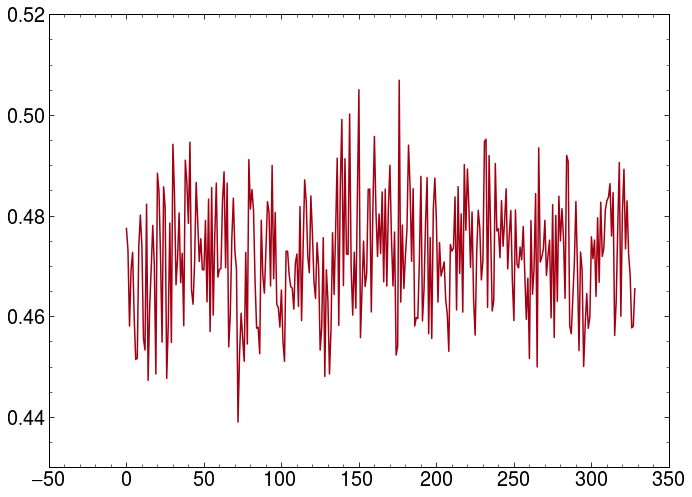

In [180]:
plt.plot(losses_tr)